In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [9]:
df = pd.read_csv('../dataset/cleaned_GLD.csv')

In [10]:
df = df[['Close']]

In [7]:
df = df.reset_index(drop=True)

In [8]:
df

,Close
0,121.330002
1,122.430000
2,121.440002
3,121.860001
4,121.529999
...,...
1364,215.270004
1365,217.820007
1366,219.429993
1367,211.600006


# SPLITTING DATA(7-2-1)

In [12]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [14]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3573.864, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3573.912, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3573.134, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3572.896, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3572.307, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3573.617, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.967 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [16]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[151.6900024 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024
 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024
 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024
 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024
 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024 151.6900024]


In [17]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 26.06761985255928
Validation RMSE: 50.269167098482214
Testing MAE: 24.685162202930403
Validation MAE: 48.45956281086956
Testing MAPE: 0.13790840940042706
Validation MAPE: 0.238800327974889


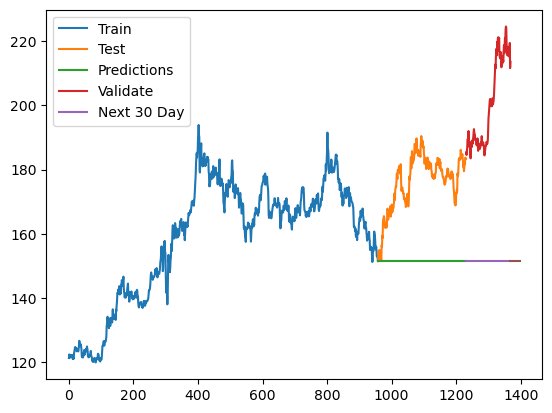

In [18]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  958
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1785.153
Date:                Fri, 08 Nov 2024   AIC                           3572.307
Time:                        09:05:42   BIC                           3577.171
Sample:                             0   HQIC                          3574.159
                                - 958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.4421      0.064     38.236      0.000       2.317       2.567
===================================================================================
Ljung-Box (L1) (Q):                   2.78   Jarque-Bera (JB):               762.64
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.66
Prob(H) (two-sided):                  0.12   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [20]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [21]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3069.704, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3076.423, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3075.415, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3075.213, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3076.134, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3072.597, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3072.201, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3076.175, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3071.466, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3076.718, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3074.208, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3073.668, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3073.034, Time=0.85 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3069.989, Time=0.32 sec

Best model:  ARIMA(2,1,2)(0,0,0)

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [22]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [23]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[180.62520858 180.85132454 181.01549561 181.10810015 181.13998887
 181.13511142 181.12144701 181.12294054 181.15428164 181.21922428
 181.3120818  181.42130186 181.53373946 181.63837801 181.7286702
 181.80320975 181.86493681 181.91940966 181.97279463 182.03015179
 182.09438858 182.16599931 182.2434805  182.3241642  182.40516209
 182.48415404 182.55985417 182.6321076  182.70167616 182.76983759]


In [24]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape)

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  24.059717722855478
Testing MAE:  22.49926438524752
Testing MAPE:  0.13210332048615728
Validation RMSE:  18.138370391138597
Validation MAE:  14.53565186706938
Validation MAPE:  0.06941631121170799


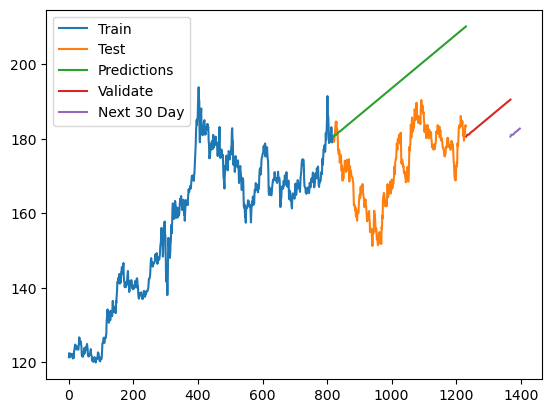

In [25]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [26]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [27]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2562.500, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2570.779, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2569.666, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2569.617, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2569.829, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2568.845, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2568.046, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2571.589, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2564.495, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2571.608, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2569.229, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2567.756, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2566.315, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2561.929, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [28]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [29]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[163.72989122 163.85053284 164.06549832 164.29505897 164.47139707
 164.55537794 164.5418417  164.45422813 164.33219944 164.21716736
 164.14023688 164.1154878  164.1394197  164.19547716 164.2613548
 164.31645805 164.34737984 164.35024424 164.32988497 164.29672734
 164.26271707 164.2376382  164.22678251 164.23035746 164.24445014
 164.262962   164.27977206 164.29047148 164.29326528 164.28895391]


In [30]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape) 

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  10.556055079472182
Testing MAE:  8.393433100953043
Testing MAPE:  0.048118246919123246
Validation RMSE:  29.417185955902518
Validation MAE:  25.80693193949783
Validation MAPE:  0.13130262388977615


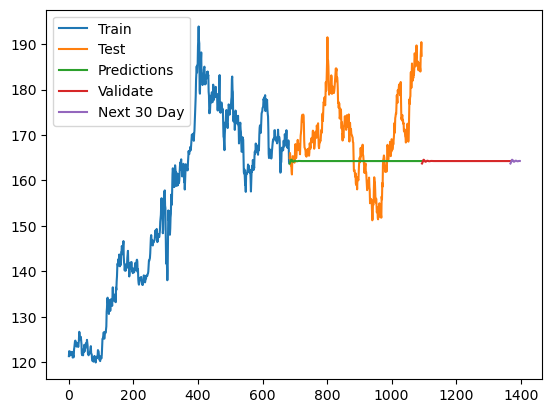

In [31]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()